<a href="https://colab.research.google.com/github/Ware-Hard-or-Soft/ML-DL-projects/blob/main/WGAN_with_weight_clipping_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implement the WGAN with weight clipping
Wasserstein GAN ([WGAN](https://arxiv.org/abs/1701.07875)) is an alternative training strategy to traditional GAN. WGAN may provide more stable learning and may avoid problems faced in traditional GAN training like mode collapse.

In [ ]:
import numpy as np

Random Seed:  999


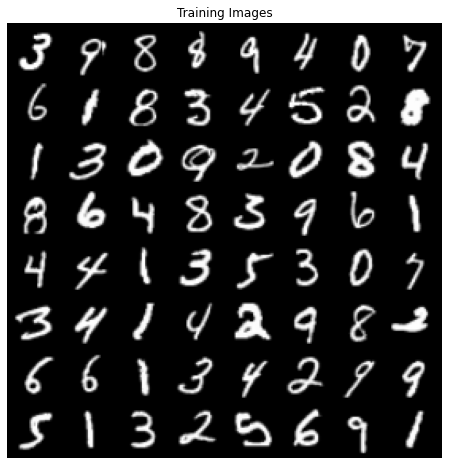

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmarks = False
os.environ['PYTHONHASHSEED'] = str(manualSeed)

# Root directory for dataset
# dataroot = "data/celeba"

# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
#image_size = 64
image_size = 32

# Number of channels in the training images. For color images this is 3
#nc = 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
#ngf = 64
ngf = 8

# Size of feature maps in discriminator
#ndf = 64
ndf = 8

# Number of training epochs
num_epochs = 5
num_epochs_wgan = 15
num_iters = 250

# Learning rate for optimizers
lr = 0.0002
lr_rms = 5e-4

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Several useful functions
def initialize_net(net_class, init_method, device, ngpu):

    # Create the generator
    net_inst = net_class(ngpu).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        net_inst = nn.DataParallel(net_inst, list(range(ngpu)))

    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.2.
    if init_method is not None:
        net_inst.apply(init_method)

    # Print the model
    print(net_inst)

    return net_inst

def plot_GAN_loss(losses, labels):

    plt.figure(figsize=(10,5))
    plt.title("Losses During Training")

    for loss, label in zip(losses, labels):
        plt.plot(loss,label=f"{label}")

    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


def plot_real_fake_images(real_batch, fake_batch):

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(fake_batch[-1],(1,2,0)))
    plt.show()


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Download the MNIST dataset
dataset = dset.MNIST(
    'data', train=True, download=True,
   transform=transforms.Compose([
       transforms.Resize(image_size), # Resize from 28 x 28 to 32 x 32 (so power of 2)
       transforms.CenterCrop(image_size),
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
   ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution, state size. nz x 1 x 1
            nn.ConvTranspose2d( nz, ngf * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True), # inplace ReLU
            # current state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # current state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # current state size. ngf x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            # current state size. nc x 32 x 32
            # Produce number between -1 and 1, as pixel values have been normalized to be between -1 and 1
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

## Discriminator

In [ ]:
class Discriminator_WGAN(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator_WGAN, self).__init__()
        self.ngpu = ngpu
        ################################ YOUR CODE ################################
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False)
            # state size. (ndf*4) x 1 x 1
            #nn.Sigmoid()  # Produce probability

        )
        ########################### END YOUR CODE ################################

    def forward(self, input):
        return self.main(input)

netG = initialize_net(Generator, weights_init, device, ngpu)
netD = initialize_net(Discriminator_WGAN, weights_init, device, ngpu)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator_WGAN(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(4, 4), strid

In [ ]:
lr_rms=5e-4
optimizerD = optim.RMSprop(netD.parameters(), lr=lr_rms)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr_rms)

######################## # END YOUR CODE ##########################

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
n_critic = 5
c = 0.01
CUDA_LAUNCH_BLOCKING=1
dataloader_iter = iter(dataloader)

print("Starting Training Loop...")
num_iters = 1000
CUDA_LAUNCH_BLOCKING=1.
for iters in range(num_iters):

    ###########################################################################
    # (1) Train Discriminator more: minimize -(mean(D(real))-mean(D(fake)))
    ###########################################################################

    for p in netD.parameters():
        p.requires_grad = True

    for idx_critic in range(n_critic):

        netD.zero_grad()

        try:
            data = next(dataloader_iter)
        except StopIteration:
            dataloader_iter = iter(dataloader)
            data = next(dataloader_iter)

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        D_real = netD(real_cpu).view(-1)

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        D_fake = netD(fake).view(-1)

        ############################ YOUR CODE ############################

        netD.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)


        D_real = netD(real_cpu).view(-1)

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        D_fake = netD(fake.detach()).view(-1)
        D_loss=-(torch.mean(D_real) - torch.mean(D_fake))

        D_loss.backward()

        nn.utils.clip_grad_value_(netD.parameters(), clip_value=c)
        optimizerD.step()



        ######################## # END YOUR CODE ##########################

    ###########################################################################
    # (2) Update G network: minimize -mean(D(fake)) (Update only once in 5 epochs)
    ###########################################################################
    for p in netD.parameters():
        p.requires_grad = False

    netG.zero_grad()

    noise = torch.randn(b_size, nz, 1, 1, device=device)
    fake = netG(noise)
    D_fake = netD(fake).view(-1)

    ################################ YOUR CODE ################################

    G_loss=-torch.mean(D_fake)
    G_loss.backward()

    optimizerG.step()

    ############################# END YOUR CODE ##############################
    # Output training stats
    if iters % 10 == 0:
        print('[%4d/%4d]   Loss_D: %6.4f    Loss_G: %6.4f'
            % (iters, num_iters, D_loss.item(), G_loss.item()))

    # Save Losses for plotting later
    G_losses.append(G_loss.item())
    D_losses.append(D_loss.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 100 == 0):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

Starting Training Loop...
[   0/1000]   Loss_D: -10.4251    Loss_G: 5.9259
[  10/1000]   Loss_D: -36.9677    Loss_G: 16.5531
[  20/1000]   Loss_D: -49.7107    Loss_G: 28.6706
[  30/1000]   Loss_D: -67.7179    Loss_G: 38.2386
[  40/1000]   Loss_D: -86.6829    Loss_G: 49.4414
[  50/1000]   Loss_D: -119.1925    Loss_G: 62.2377
[  60/1000]   Loss_D: -145.3337    Loss_G: 74.0217
[  70/1000]   Loss_D: -171.9211    Loss_G: 86.5118
[  80/1000]   Loss_D: -194.9999    Loss_G: 98.8049
[  90/1000]   Loss_D: -223.2481    Loss_G: 112.2058
[ 100/1000]   Loss_D: -250.4201    Loss_G: 124.9717
[ 110/1000]   Loss_D: -281.0286    Loss_G: 138.1055
[ 120/1000]   Loss_D: -311.9628    Loss_G: 151.6187
[ 130/1000]   Loss_D: -342.1707    Loss_G: 169.8764
[ 140/1000]   Loss_D: -373.7446    Loss_G: 185.1667
[ 150/1000]   Loss_D: -402.6410    Loss_G: 203.4751
[ 160/1000]   Loss_D: -433.2814    Loss_G: 220.1583
[ 170/1000]   Loss_D: -458.8970    Loss_G: 237.1873
[ 180/1000]   Loss_D: -487.4432    Loss_G: 248.4337
[

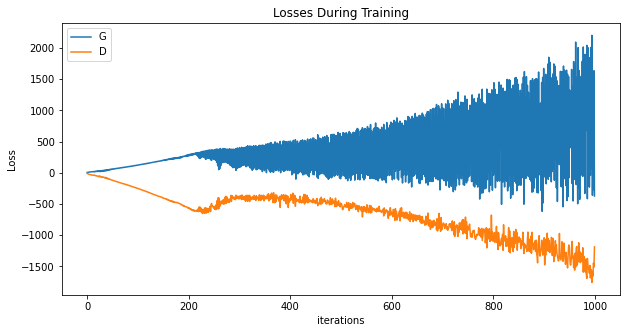

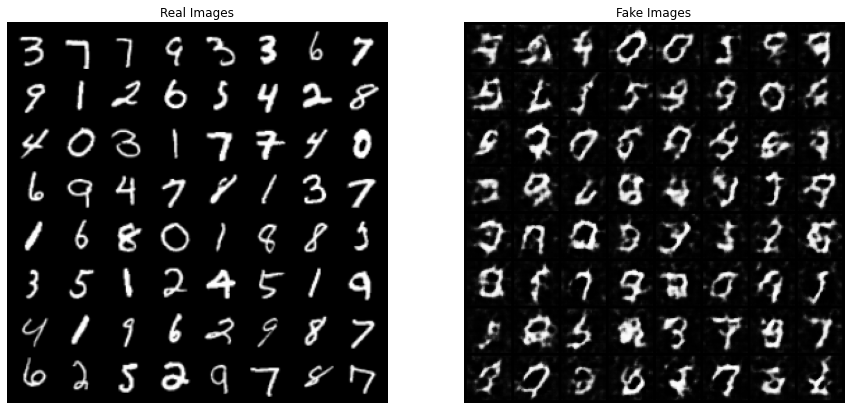

In [ ]:
# plot the loss for generator and discriminator
plot_GAN_loss([G_losses, D_losses], ["G", "D"])

# Grab a batch of real images from the dataloader
plot_real_fake_images(next(iter(dataloader)), img_list)